# Предсказание времени исправления багов в gcc

Задача состоит в предсказании времени, необходимого на исправление багов, на основе описания бага.

Набор данных содержит многолетние логи.

### Импорт нужных модулей

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import category_encoders as ce  # библиотека для кодирования категориальных признаков
import matplotlib.pyplot as plt
%matplotlib inline

### Читаем данные

In [2]:
data_url = 'https://raw.githubusercontent.com/Sandro295/Masters-ML/main/gcc_bug_report_data.csv'
data_raw = pd.read_csv(data_url)

data_raw.shape

(10000, 19)

Датасет состоит из _10 000_ записей и _19_ признаков

Посмотрим на загруженные данные

In [3]:
data_raw.head(5)

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
0,GCC-49282,2011-06-04,middle-end,GCC,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,fixed,1,resolved,4,2011-10-07,0,9,2011-10-07,125,normal,2
1,GCC-36574,2008-06-19,middle-end,GCC,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,fixed,1,resolved,4,2008-07-18,0,5,2008-07-18,29,normal,2
2,GCC-77269,2016-08-16,middle-end,GCC,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,fixed,1,resolved,4,2016-08-22,0,5,2016-08-22,6,normal,2
3,GCC-78479,2016-11-22,fortran,GCC,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,fixed,1,resolved,4,2016-11-22,0,6,2016-11-22,0,normal,2
4,GCC-632,2000-10-12,c++,GCC,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,fixed,1,resolved,4,2003-07-25,0,5,2001-02-04,115,normal,2


Видно, что данные состоят как из числовых, так и категориальных признаков.

## Список признаков и их описания

In [7]:
data_raw.dtypes

bug_id                  category
creation_date           category
component_name          category
product_name            category
short_description       category
long_description        category
assignee_name           category
reporter_name           category
resolution_category     category
resolution_code            int64
status_category         category
status_code                int64
update_date             category
quantity_of_votes          int64
quantity_of_comments       int64
resolution_date         category
bug_fix_time               int64
severity_category       category
severity_code              int64
dtype: object

Заранее поменяем тип у категориальных признаков (с _object_ на _category_)

In [5]:
for column in data_raw.select_dtypes(['object']):
    data_raw[column] = data_raw[column].astype('category')

In [8]:
data_raw.dtypes

bug_id                  category
creation_date           category
component_name          category
product_name            category
short_description       category
long_description        category
assignee_name           category
reporter_name           category
resolution_category     category
resolution_code            int64
status_category         category
status_code                int64
update_date             category
quantity_of_votes          int64
quantity_of_comments       int64
resolution_date         category
bug_fix_time               int64
severity_category       category
severity_code              int64
dtype: object

### Входные признаки

####  Числовые признаки

* __bug_id__ - уникальный идентификатор бага
* __creation_date__ - дата создания тикета
* __resolution_category__ - статус задачи
* __status_code__ - код задачи
* __update_date__ - дата последнего обновления тикета
* __quantity_of_votes__ - количество голосов в тикете
* __quantity_of_comments__ - количество комментариев
* __resolution_date__ - дата закрытия тикета
* __bug_fix_time__ - время исправления бага
* __severity_category__ - уровень критичности бага
* __severity_code__ - код уровня критичности бага

####  Категориальные признаки

* __component_name__ - компонент продукта с ошибкой
* __product_name__ - продукт с ошибкой
* __assignee_name__ - никнейм взявшего тикет
* __reporter_name__ - никнейм ответственного за проверку

####  Текстовые признаки
* __short_description__ - краткое описание появившейся проблемы
* __long_description__ - подробное описание проблемы


### Выходной признак

* __bug_fix_time__ - время разрешения тикета

## Чистка данных

In [60]:
data_raw.describe()

,resolution_code,status_code,quantity_of_votes,quantity_of_comments,bug_fix_time,severity_code
count,10000.0,10000.000000,10000.0,10000.000000,10000.0000,10000.00000
mean,1.0,4.019400,0.0,8.145000,225.8268,2.22120
std,0.0,0.196029,0.0,6.553859,516.6366,0.79758
min,1.0,4.000000,0.0,1.000000,-527.0000,1.00000
25%,1.0,4.000000,0.0,4.000000,3.0000,2.00000
50%,1.0,4.000000,0.0,6.000000,27.0000,2.00000
75%,1.0,4.000000,0.0,10.000000,188.0000,2.00000
max,1.0,6.000000,0.0,124.000000,5351.0000,6.00000


Первым делом очистим данные. 
__xx_category__ и __xx_code__ несут одинаковую информацию.
__product_name__ в этом датасете один. __resolution_category__ везде 1.
__update_date__ и __resolution_date__ как правило одинаковы.
__quantity_of_votes__ везде 0.


In [22]:
data_raw.isna().sum()

bug_id                   0
creation_date            0
component_name           0
product_name             0
short_description        6
long_description        14
assignee_name            0
reporter_name            0
resolution_category      0
resolution_code          0
status_category          0
status_code              0
update_date              0
quantity_of_votes        0
quantity_of_comments     0
resolution_date          0
bug_fix_time             0
severity_category        0
severity_code            0
dtype: int64

Также избавимся от строк с пропущенными данными.

In [61]:
data = data_raw.drop(['severity_category', 'product_name', 'update_date', 'resolution_category', 'resolution_code', 'status_category', 'quantity_of_votes'], axis=1).dropna()

In [44]:
data_raw.describe(include=['category'])

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,status_category,update_date,resolution_date,severity_category
count,10000,10000,10000,10000,9994,9986,10000,10000,10000,10000,10000,10000,10000
unique,10000,4846,55,2,9928,9958,270,3287,1,2,3642,4490,6
top,CLASSPATH-16040,2000-12-20,c++,GCC,Internal compiler error,,unassigned,hjl.tools,fixed,resolved,2003-07-25,2005-07-23,normal
freq,1,77,2217,9731,9,19,5149,292,10000,9903,1553,58,8895


In [62]:
data.describe(include=['category'])

,bug_id,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,resolution_date
count,9980,9980,9980,9980,9980,9980,9980,9980
unique,9980,4840,55,9914,9953,270,3275,4487
top,CLASSPATH-16040,2000-12-20,c++,Internal compiler error,,unassigned,hjl.tools,2005-07-23
freq,1,77,2213,9,19,5136,292,58


In [63]:
data.head(5)

,bug_id,creation_date,component_name,short_description,long_description,assignee_name,reporter_name,status_code,quantity_of_comments,resolution_date,bug_fix_time,severity_code
0,GCC-49282,2011-06-04,middle-end,malloc corruption in large lto1-wpa run during...,A large lto1-wpa run with 20110603 results now...,unassigned,andi-gcc,4,9,2011-10-07,125,2
1,GCC-36574,2008-06-19,middle-end,[4.4 Regression] build broken with cgraph changes,With r136888 cris-elf built (and had just 4 re...,unassigned,hp,4,5,2008-07-18,29,2
2,GCC-77269,2016-08-16,middle-end,__builtin_isinf_sign does not work for __float128,The __builtin_isinf_sign folding does\n\n ...,jsm28,jsm28,4,5,2016-08-22,6,2
3,GCC-78479,2016-11-22,fortran,ICE in gfc_apply_init at fortran/expr.c:4135,With valid code down to at least 4.8 :\n\n\n$ ...,kargl,gerhard.steinmetz.fortran,4,6,2016-11-22,0,2
4,GCC-632,2000-10-12,c++,Internal compiler error in `layout_decl' at st...,g++ -I/home/leila/Sources/Include -O2 -Wall -...,unassigned,lkh,4,5,2001-02-04,115,2


## Визуализация и предварительный анализ данных

### Описательная статистика матрицы данных

#### Информация о числовых признаках

In [64]:
data.describe()

,status_code,quantity_of_comments,bug_fix_time,severity_code
count,9980.000000,9980.000000,9980.000000,9980.000000
mean,4.019038,8.147094,225.961222,2.221443
std,0.194210,6.557003,516.901518,0.798122
min,4.000000,1.000000,-527.000000,1.000000
25%,4.000000,4.000000,3.000000,2.000000
50%,4.000000,6.000000,27.000000,2.000000
75%,4.000000,10.000000,188.000000,2.000000
max,6.000000,124.000000,5351.000000,6.000000


По таблице можно увидеть, что какие-то баги решались за отрицательное время, что можно трактовать как позднее создание тикета или выброс, избавимся от него. 

### Визуализация данных

В процессе визуализации могут проявиться некоторые особенности данных, с которыми необходимо будет разобраться

Посмотрим на сбалансированность/несбалансированность классов

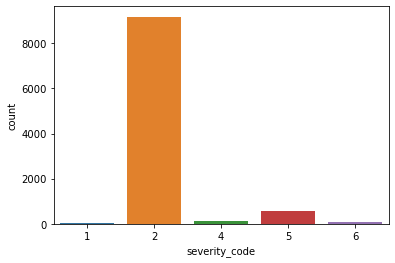

In [52]:
sns.countplot(x='severity_code', data=data)
pass

Видно, что классы ___несбалансированны___. Впоследствии имеет смысл попытаться избавиться от несбалансированности.

У большинства багов одинаковая важность.

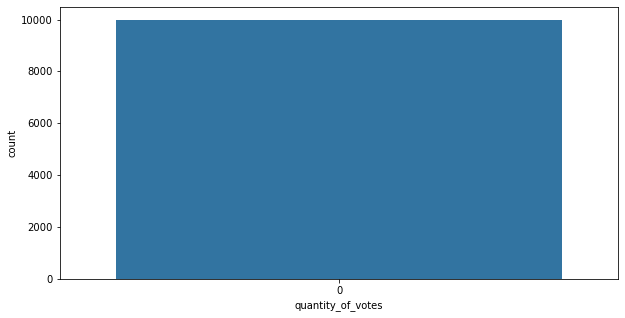

In [59]:
plt.figure(figsize=(10, 5))
sns.countplot(x='quantity_of_votes', data=data)
pass

Построим графики зависимостей каждого количественного признака с каждым

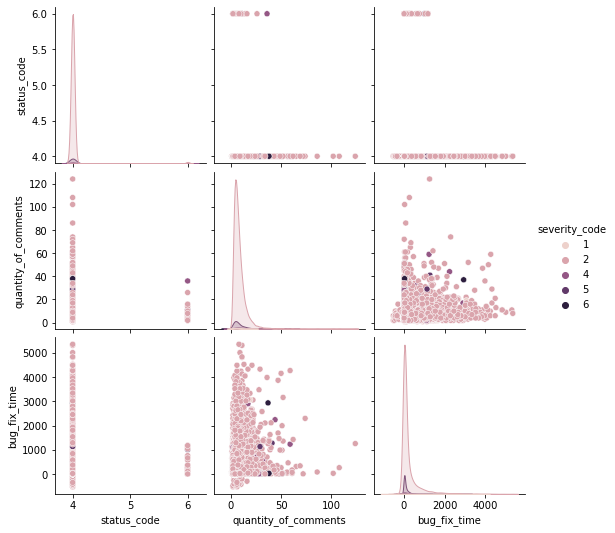

In [66]:
sns.pairplot(data, hue='severity_code')

Построим матрицу корреляции для количественных признаков и визуализируем её

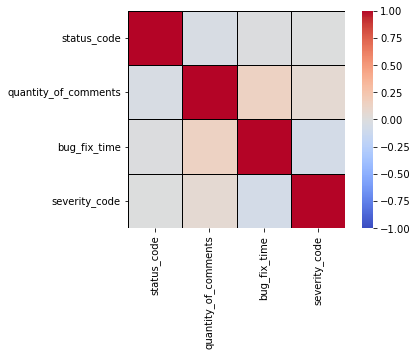

In [67]:
corr_mat = data.corr()

sns.heatmap(corr_mat, square=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=1, linecolor="black")
pass

Видно, что среди количественных признаков сильно скореллированных не оказалось

Попробуем вычислить матрицу корреляции для всех признаков, но перед этим временно факторизируем категориальные признаки

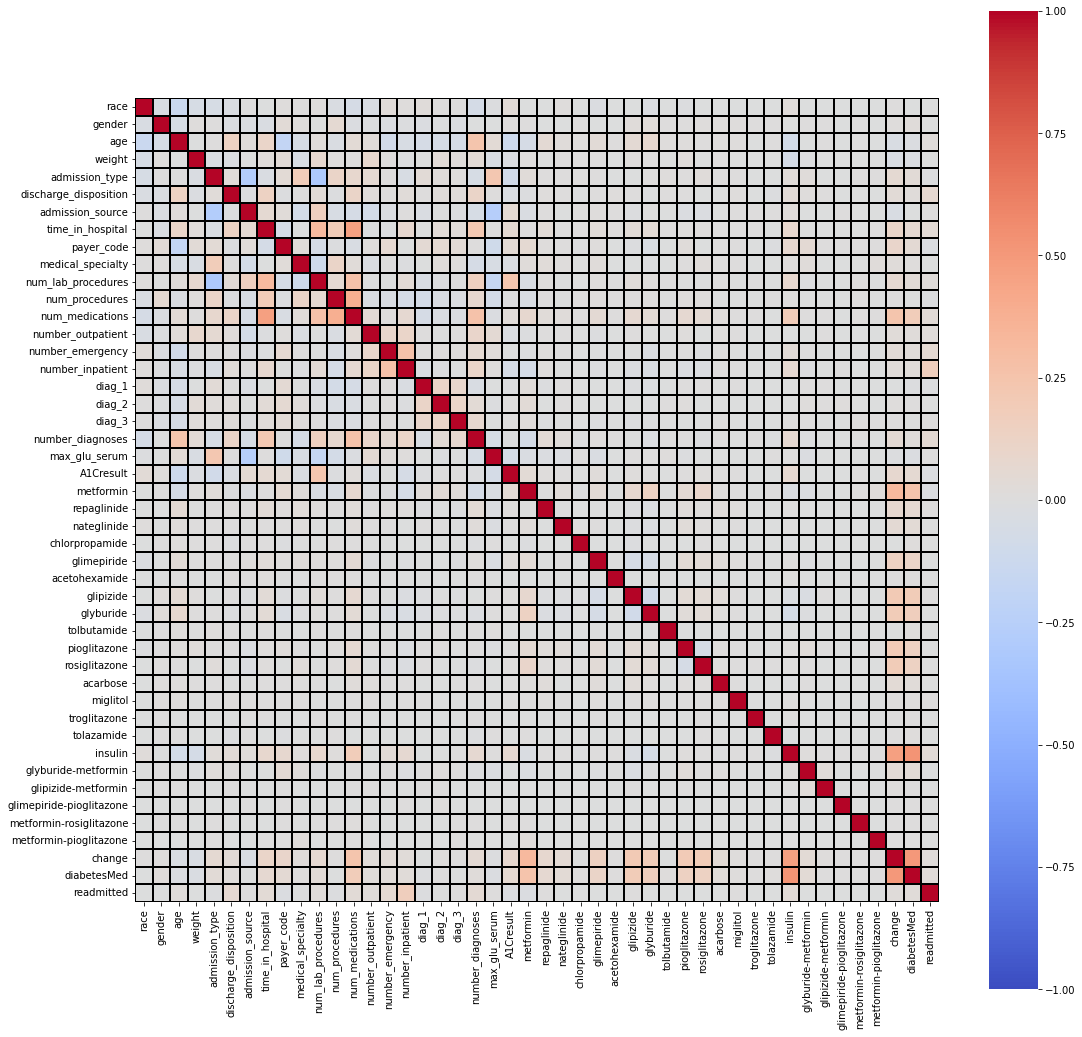

In [32]:
df_f = data_raw.copy()
for column in df_f.select_dtypes(['category']):
    df_f[column] = pd.factorize(df_f[column])[0]

corr_mat_f = df_f.corr()

plt.figure(figsize=(18, 18))
sns.heatmap(corr_mat_f, square=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=1, linecolor="black")
pass

Видим, что и среди всех признаков сильно скореллированных нет

Выведем пары признаков, для которых коэффициенты корреляции, больше заданного значения

In [33]:
corr_mat_f.where(np.triu(corr_mat_f > 0.4, k=1)).stack().sort_values(ascending=False)

insulin           diabetesMed        0.528249
change            diabetesMed        0.506360
insulin           change             0.468251
time_in_hospital  num_medications    0.466137
dtype: float64

Несмотря на то, что сильной связи между признаками нет, всё же существует средняя связь между _insulin_, _change_, _diabetesMed_, по той причине, что инсулин назначали как лекарство от диабета, а также между _time_in_hospital_ и _num_medications_, т.к. чем больше времени пациент проводит в больнице (по тем или иным причинам, оставаясь при этом именно пациентом), тем больше лекарств нужно, чтобы его исцелить.

## Обработка пропущенных значений

Оценим, сколько пропущенных значений содержится в данном датасете. Для этого посмотрим на процентное содержание пропущенных значений.

In [34]:
(data_raw.isna().sum() / data_raw.shape[0] * 100).sort_values(ascending=False)

weight                      96.858387
medical_specialty           49.081690
payer_code                  39.557600
admission_source             6.663522
admission_type               5.199336
discharge_disposition        3.627055
race                         2.231656
diag_3                       1.398347
diag_2                       0.351798
diag_1                       0.020636
pioglitazone                 0.000000
tolbutamide                  0.000000
rosiglitazone                0.000000
acarbose                     0.000000
miglitol                     0.000000
troglitazone                 0.000000
tolazamide                   0.000000
glipizide-metformin          0.000000
insulin                      0.000000
glyburide-metformin          0.000000
glipizide                    0.000000
glimepiride-pioglitazone     0.000000
metformin-rosiglitazone      0.000000
metformin-pioglitazone       0.000000
change                       0.000000
diabetesMed                  0.000000
glyburide   

Видим, что есть как признаки, в которых нет пропущенных значений, так и те признаки, в которых пропущено >90% значений. Также заметим, что для числовых признаков нет пропущенных значений.

Ввиду того, что для признаков _race_, _diag_3_, _diag_2_, _diag_1_ мало пропущенных значений (<3%), можно удалить из таблицы все строки, в которых встречаются соответствующие отсутствующие значения.

In [35]:
data_raw.dropna(subset=['race', 'diag_3', 'diag_2', 'diag_1'], inplace=True)
data_raw.shape

(98052, 46)

Имеет смысл удалить признак _payer_code_, для которого пропущено почти 40% записей по той причине, что он, очевидно, никак не влияет на физическое состояние пациента и будет несущественным в задаче предсказания ранней повторной госпитализации

In [36]:
data_raw.drop(['payer_code'], axis=1, inplace=True)
data_raw.shape

(98052, 45)

Признак _weight_ также придется удалить, потому что он отсутствует почти во всех записях (почти 97%) и его невозможно восстановить

In [37]:
data_raw.drop(['weight'], axis=1, inplace=True)
data_raw.shape

(98052, 44)

Для признаков _admission_source_ и _admission_type_ есть специальное значение _'Not Available'_, на которое можно заменить пропущенные значения

In [38]:
data_raw['admission_source'].fillna('Not Available', inplace=True)
data_raw['admission_type'].fillna('Not Available', inplace=True)

А для оставшихся признаков _discharge_disposition_ и _medical_specialty_ имеет смысл специально добавить значение _'Not Available'_, на которое заменим пропущенные значения

In [39]:
data_raw['discharge_disposition'] = data_raw['discharge_disposition'].cat.add_categories('Not Available')
data_raw['discharge_disposition'].fillna('Not Available', inplace=True)

data_raw['medical_specialty'] = data_raw['medical_specialty'].cat.add_categories('Not Available')
data_raw['medical_specialty'].fillna('Not Available', inplace=True)

In [40]:
(data_raw.isna().sum() / data_raw.shape[0] * 100).sort_values(ascending=False)

race                        0.0
gender                      0.0
glimepiride                 0.0
acetohexamide               0.0
glipizide                   0.0
glyburide                   0.0
tolbutamide                 0.0
pioglitazone                0.0
rosiglitazone               0.0
acarbose                    0.0
miglitol                    0.0
troglitazone                0.0
tolazamide                  0.0
insulin                     0.0
glyburide-metformin         0.0
glipizide-metformin         0.0
glimepiride-pioglitazone    0.0
metformin-rosiglitazone     0.0
metformin-pioglitazone      0.0
change                      0.0
diabetesMed                 0.0
chlorpropamide              0.0
nateglinide                 0.0
repaglinide                 0.0
num_medications             0.0
age                         0.0
admission_type              0.0
discharge_disposition       0.0
admission_source            0.0
time_in_hospital            0.0
medical_specialty           0.0
num_lab_

In [41]:
data_raw.describe(include=['category']).T

,count,unique,top,freq
race,98052,5,Caucasian,75079
gender,98052,2,Female,52833
age,98052,10,[70-80),25305
admission_type,98052,7,Emergency,52178
discharge_disposition,98052,26,Discharged to home,57609
admission_source,98052,16,Emergency Room,55951
medical_specialty,98052,73,Not Available,48318
diag_1,98052,713,428,6730
diag_2,98052,740,428,6517
diag_3,98052,786,250,11208


Заметим, что после обработки пропущенных значений _metformin-rosiglitazone_ стал принимать только одно уникальное значение, а потому этот признак можно убрать из таблицы

In [42]:
data_raw.drop(['metformin-rosiglitazone'], axis=1, inplace=True)

data_raw.shape

(98052, 43)

## Обработка категориальных признаков

### Получение числового признака _age_ из категориального

Сначала обработаем признак _age_. Он принимает значения в виде 10-летнего интервала, а потому имеет смысл заменить интервал на среднее значение интервала, тем самым получив числовой признак

In [43]:
data_raw['age'].unique()

['[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)', '[0-10)']
Categories (10, object): ['[0-10)', '[10-20)', '[20-30)', '[30-40)', ..., '[60-70)', '[70-80)',
                          '[80-90)', '[90-100)']

Все интервалы выглядят следующим образом: $[10 * i; 10 * (i + 1))$ для всех i от 0 до 9. Соответственно, каждый такой интервал можно заменить на $10*i + 5*(i+1)$ для всех i от 0 до 9

In [44]:
age = data_raw['age'].copy()

for i in range(0, 10):
    interval_str = '[' + str(10 * i) + '-' + str(10 * (i + 1)) + ')'
    mean_of_interval = 10 * i + 10 * (i + 1) // 2
    age = age.replace(interval_str, mean_of_interval)  # заменяем интервал на среднее

age = pd.to_numeric(age)  # меняем тип на числовой
data_raw.drop(['age'], axis=1, inplace=True)  # удаляем из исходной таблицы старый категориальный признак age
data_raw = pd.concat([age, data_raw], axis=1)  # добавляем новый числовой признак age

In [45]:
data_raw.dtypes

age                            int64
race                        category
gender                      category
admission_type              category
discharge_disposition       category
admission_source            category
time_in_hospital               int64
medical_specialty           category
num_lab_procedures             int64
num_procedures                 int64
num_medications                int64
number_outpatient              int64
number_emergency               int64
number_inpatient               int64
diag_1                      category
diag_2                      category
diag_3                      category
number_diagnoses               int64
max_glu_serum               category
A1Cresult                   category
metformin                   category
repaglinide                 category
nateglinide                 category
chlorpropamide              category
glimepiride                 category
acetohexamide               category
glipizide                   category
g

Будет правильным решением сейчас отдельно сохранить таблицу исключительно с количественными признаками (тех, для которых на данный момент dtype == int64). Впоследствии это облегчит процесс нормализации данных, т.к. нормализируем мы только количественные признаки.

In [46]:
df_num = data_raw.select_dtypes(['int64'])  # num - сокращение от numeric

In [47]:
df_num

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
1,20,3,59,0,18,0,0,0,9
2,35,2,11,5,13,2,0,1,6
3,50,2,44,1,16,0,0,0,7
4,65,1,51,0,8,0,0,0,5
5,80,3,31,6,16,0,0,0,9
...,...,...,...,...,...,...,...,...,...
101761,110,3,51,0,16,0,0,0,9
101762,125,5,33,3,18,0,0,1,9
101763,110,1,53,0,9,1,0,0,13
101764,125,10,45,2,21,0,0,1,9


Сейчас можно временно удалить из исходной таблицы все количественные признаки. После обработки категориальных признаков, можно будет объединить всё обратно в единую таблицу

In [48]:
data_raw.drop(df_num, axis=1, inplace=True)

### Предварительная категоризация заболеваний

In [49]:
len(data_raw['diag_1'].unique())

713

In [50]:
len(data_raw['diag_2'].unique())

740

In [51]:
len(data_raw['diag_3'].unique())

786

Для признаков _diag_1_, _diag_2_, _diag_3_ слишком много уникальных значений (>700). Т.к. эти признаки обозначают диагноз (заболевание), то имеет смысл сгруппировать эти болезни в следующие категории:

* ___Circulatory___ - Заболевания системы кровообращения (коды МКБ9: __390–459__, __785__)
* ___Respiratory___ - Заболевания дыхательной системы (коды МКБ9: __460–519__, __786__)
* ___Digestive___ - Заболевания пищеварительной системы (коды МКБ9: __520–579__, __787__)
* ___Diabetes___ - Сахарный диабет (коды МКБ9: __250.xx__)
* ___Injury___ - Травмы и отравления (коды МКБ9: __800–999__)
* ___Musculoskeletal___ - Заболевания опорно-двигательного аппарата и соединительной ткани (коды МКБ9: __710–739__)
* ___Genitourinary___ - Заболевания мочеполовой системы (коды МКБ9: __580–629__, __788__)
* ___Neoplasms___ - Новообразования (коды МКБ9: __140–239__)
* ___Other___ - Другие заболевания, не принадлежащие ни одной из вышеперечисленных категорий

Также, как и с числовыми признаками, скопируем часть исходной таблицы с признаками _diag_1_, _diag_2_, _diag_3_

In [52]:
diags = ['diag_1', 'diag_2', 'diag_3']

df_diags = data_raw[diags].copy()

In [53]:
diag_categories = [
    'Circulatory', 
    'Respiratory', 
    'Digestive', 
    'Diabetes', 
    'Injury', 
    'Musculoskeletal', 
    'Genitourinary', 
    'Neoplasms', 
    'Other'
]

for diag in diags:
    df_diags[diag] = df_diags[diag].cat.set_categories(diag_categories)

Для удобства можно ввести функцию, принимающую на вход код МКБ9 (ICD9), а на выходе возвращающую название категории заболевания. Но не смотря на то, что мы избавились от пропущенных значений, все же есть валидные коды, начинающиеся с _'E'_ и _'V'_. Эти заболевания должны быть отнесены к категории _'Other'_.

In [54]:
def get_diag_category(icd9_code: str) -> str:
    if icd9_code[0] == 'E' or icd9_code[0] == 'V':
        return 'Other'
    
    icd9_code = int(float(icd9_code))
    
    if 390 <= icd9_code <= 459 or icd9_code == 785:
        return 'Circulatory'
    if 460 <= icd9_code <= 519 or icd9_code == 786:
        return 'Respiratory'
    if 520 <= icd9_code <= 579 or icd9_code == 787:
        return 'Digestive'
    if icd9_code == 250:
        return 'Diabetes'
    if 800 <= icd9_code <= 999:
        return 'Injury'
    if 710 <= icd9_code <= 739:
        return 'Musculoskeletal'
    if 580 <= icd9_code <= 629 or icd9_code == 788:
        return 'Genitourinary'
    if 140 <= icd9_code <= 239:
        return 'Neoplasms'
    
    return 'Other'

Перебирая все строки исходной таблицы, с помощью функции _get_diag_category()_ заполняем новую таблицу с признаками diag_1, diag_2, diag_3

In [55]:
for index, row in data_raw.iterrows():
    for diag in diags:
        df_diags.loc[index, diag] = get_diag_category(data_raw.loc[index, diag])

In [56]:
df_diags.T

,1,2,3,4,5,6,7,8,9,10,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
diag_1,Other,Other,Other,Neoplasms,Circulatory,Circulatory,Circulatory,Circulatory,Circulatory,Diabetes,...,Injury,Respiratory,Other,Circulatory,Other,Diabetes,Digestive,Other,Injury,Digestive
diag_2,Diabetes,Diabetes,Diabetes,Neoplasms,Circulatory,Circulatory,Respiratory,Circulatory,Neoplasms,Circulatory,...,Genitourinary,Respiratory,Other,Other,Circulatory,Other,Other,Genitourinary,Other,Digestive
diag_3,Other,Other,Circulatory,Diabetes,Diabetes,Other,Diabetes,Other,Respiratory,Injury,...,Circulatory,Respiratory,Other,Diabetes,Circulatory,Circulatory,Digestive,Other,Injury,Digestive


Т.к. мы разбили все заболевания на различные категории, а признаки могут принимать значения не всех кодов заболеваний, возникают неиспользуемые категории. От них следует избавиться, чтобы в последующем (при кодировании) уменьшить размерности векторов.

In [57]:
for diag in diags:
    df_diags[diag] = df_diags[diag].cat.remove_unused_categories()

Теперь заменяем "старые" признаки _diag_1_, _diag_2_, _diag_3_ на их "новые" аналоги.

In [58]:
data_raw.drop(diags, axis=1, inplace=True)    # удаляем из исходной таблицы "старые" признаки diag_1, diag_2, diag_3
data_raw = pd.concat([data_raw, df_diags], axis=1)  # добавляем новые признаки diag_1, diag_2, diag_3

In [59]:
data_raw.describe(include=['category']).T

,count,unique,top,freq
race,98052,5,Caucasian,75079
gender,98052,2,Female,52833
admission_type,98052,7,Emergency,52178
discharge_disposition,98052,26,Discharged to home,57609
admission_source,98052,16,Emergency Room,55951
medical_specialty,98052,73,Not Available,48318
max_glu_serum,98052,4,None,92844
A1Cresult,98052,4,None,81859
metformin,98052,4,No,78807
repaglinide,98052,4,No,96529


### Кодирование номинальных  признаков

Сначала все бинарные признаки заменим на числовые (0 и 1)

In [60]:
cat_columns = data_raw.select_dtypes(['category'])

for column in cat_columns:
    if data_raw[column].nunique() == 2:
        data_raw[column] = pd.factorize(data_raw[column])[0]

In [61]:
data_raw.describe(include=['category']).T

,count,unique,top,freq
race,98052,5,Caucasian,75079
admission_type,98052,7,Emergency,52178
discharge_disposition,98052,26,Discharged to home,57609
admission_source,98052,16,Emergency Room,55951
medical_specialty,98052,73,Not Available,48318
max_glu_serum,98052,4,None,92844
A1Cresult,98052,4,None,81859
metformin,98052,4,No,78807
repaglinide,98052,4,No,96529
nateglinide,98052,4,No,97361


Все признаки, кроме _discharge_disposition_, _admission_source_ и _medical_specialty_, содержат число уникальных значений >2 и <10, а, значит, для их кодирования логично применить метод бинаризации (one-hot encoding), предварительно убрав неиспользуемые категории

In [62]:
cat_columns = data_raw.select_dtypes(['category'])

for column in cat_columns:
    if data_raw[column].nunique() < 10:
        data_raw[column] = data_raw[column].cat.remove_unused_categories()  # убираю неиспользуемые категории
        df_dummies = pd.get_dummies(data_raw[column], prefix=column)  # one-hot encoding
        data_raw.drop(column, axis=1, inplace=True)                   # удаляем из исходной таблицы "старые" признаки
        data_raw = pd.concat([data_raw, df_dummies], axis=1)                # добавляем бинаризованные ("новые") признаки

In [63]:
data_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,98052.0,0.461174,0.498493,0.0,0.0,0.0,1.0,1.0
acetohexamide,98052.0,0.000010,0.003194,0.0,0.0,0.0,0.0,1.0
tolbutamide,98052.0,0.000224,0.014977,0.0,0.0,0.0,0.0,1.0
troglitazone,98052.0,0.000031,0.005531,0.0,0.0,0.0,0.0,1.0
glipizide-metformin,98052.0,0.000133,0.011514,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
diag_3_Injury,98052.0,0.019275,0.137492,0.0,0.0,0.0,0.0,1.0
diag_3_Musculoskeletal,98052.0,0.018990,0.136490,0.0,0.0,0.0,0.0,1.0
diag_3_Genitourinary,98052.0,0.066567,0.249271,0.0,0.0,0.0,0.0,1.0
diag_3_Neoplasms,98052.0,0.018562,0.134971,0.0,0.0,0.0,0.0,1.0


Признаки _discharge_disposition_, _admission_source_ и _medical_specialty_ содержат большое число уникальных значений, поэтому рассмотренные выше методы для кодирования не годятся. Для кодирования применим метод бинарного кодирования из библиотеки _category_encoders_

Кодируем признак _discharge_disposition_ и заменяем "старый" признак "новым" кодированным.

In [64]:
encoder = ce.BinaryEncoder(return_df=True)
df_discharge_disposition = encoder.fit_transform(data_raw['discharge_disposition'])
df_discharge_disposition.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   discharge_disposition_0  98052 non-null  int64
 1   discharge_disposition_1  98052 non-null  int64
 2   discharge_disposition_2  98052 non-null  int64
 3   discharge_disposition_3  98052 non-null  int64
 4   discharge_disposition_4  98052 non-null  int64
dtypes: int64(5)
memory usage: 4.5 MB


In [65]:
data_raw.drop(['discharge_disposition'], axis=1, inplace=True)
data_raw = pd.concat([data_raw, df_discharge_disposition], axis=1)

Кодируем признак _admission_source_ и заменяем "старый" признак "новым" кодированным.

In [66]:
encoder = ce.BinaryEncoder(return_df=True)
df_admission_source = encoder.fit_transform(data_raw['admission_source'])
df_admission_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   admission_source_0  98052 non-null  int64
 1   admission_source_1  98052 non-null  int64
 2   admission_source_2  98052 non-null  int64
 3   admission_source_3  98052 non-null  int64
 4   admission_source_4  98052 non-null  int64
dtypes: int64(5)
memory usage: 4.5 MB


In [67]:
data_raw.drop(['admission_source'], axis=1, inplace=True)
data_raw = pd.concat([data_raw, df_admission_source], axis=1)

Кодируем признак _medical_specialty_ и заменяем "старый" признак "новым" кодированным.

In [68]:
encoder = ce.BinaryEncoder(return_df=True)
df_medical_specialty = encoder.fit_transform(data_raw['medical_specialty'])
df_medical_specialty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98052 entries, 1 to 101765
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   medical_specialty_0  98052 non-null  int64
 1   medical_specialty_1  98052 non-null  int64
 2   medical_specialty_2  98052 non-null  int64
 3   medical_specialty_3  98052 non-null  int64
 4   medical_specialty_4  98052 non-null  int64
 5   medical_specialty_5  98052 non-null  int64
 6   medical_specialty_6  98052 non-null  int64
dtypes: int64(7)
memory usage: 6.0 MB


In [69]:
data_raw.drop(['medical_specialty'], axis=1, inplace=True)
data_raw = pd.concat([data_raw, df_medical_specialty], axis=1)

In [70]:
data_raw.describe()

,gender,acetohexamide,tolbutamide,troglitazone,glipizide-metformin,glimepiride-pioglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,...,admission_source_2,admission_source_3,admission_source_4,medical_specialty_0,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,medical_specialty_5,medical_specialty_6
count,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,...,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,0.461174,0.000010,0.000224,0.000031,0.000133,0.000010,0.000010,0.538225,0.231530,0.112858,...,0.318984,0.061702,0.678915,0.000938,0.032014,0.044456,0.154041,0.225136,0.277802,0.671450
std,0.498493,0.003194,0.014977,0.005531,0.011514,0.003194,0.003194,0.498539,0.421813,0.316421,...,0.466085,0.240615,0.466896,0.030617,0.176037,0.206107,0.360990,0.417674,0.447917,0.469688
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Нормализация количественных признаков

Проведем стандартизацию (линейное преобразование, приводящее все значения к нулевому среднему и единичному стандартному отклонению) всех признаков

In [71]:
df_num = (df_num - df_num.mean(axis=0)) / df_num.std(axis=0)

In [72]:
df_num.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04
mean,4.058091e-17,2.087018e-17,-1.791357e-16,5.543642e-18,9.855364e-17,1.159455e-18,2.782691e-17,8.319086e-17,-1.669615e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.929255e+00,-1.143311e+00,-2.138240e+00,-7.905951e-01,-1.864660e+00,-2.932773e-01,-2.147255e-01,-5.089364e-01,-2.462300e+00
25%,-7.222366e-01,-8.092063e-01,-6.163054e-01,-7.905951e-01,-6.313859e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,-8.251672e-01
50%,-8.083288e-02,-1.409960e-01,4.319950e-02,-2.052777e-01,-1.380761e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,2.662548e-01
75%,5.605708e-01,5.272143e-01,7.027044e-01,3.800396e-01,4.785611e-01,-2.932773e-01,-2.147255e-01,2.778300e-01,8.119658e-01
max,1.843378e+00,3.200055e+00,4.507540e+00,2.721309e+00,8.001535e+00,3.243318e+01,8.038794e+01,1.601316e+01,4.631943e+00


Теперь объединим стандартизованные количественные признаки с уже обработанными категориальными признаками

In [73]:
data_raw = pd.concat([df_num, data_raw], axis=1)

In [74]:
data_raw.describe()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,gender,...,admission_source_2,admission_source_3,admission_source_4,medical_specialty_0,medical_specialty_1,medical_specialty_2,medical_specialty_3,medical_specialty_4,medical_specialty_5,medical_specialty_6
count,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,9.805200e+04,98052.000000,...,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000,98052.000000
mean,4.058091e-17,2.087018e-17,-1.791357e-16,5.543642e-18,9.855364e-17,1.159455e-18,2.782691e-17,8.319086e-17,-1.669615e-16,0.461174,...,0.318984,0.061702,0.678915,0.000938,0.032014,0.044456,0.154041,0.225136,0.277802,0.671450
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.498493,...,0.466085,0.240615,0.466896,0.030617,0.176037,0.206107,0.360990,0.417674,0.447917,0.469688
min,-3.929255e+00,-1.143311e+00,-2.138240e+00,-7.905951e-01,-1.864660e+00,-2.932773e-01,-2.147255e-01,-5.089364e-01,-2.462300e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.222366e-01,-8.092063e-01,-6.163054e-01,-7.905951e-01,-6.313859e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,-8.251672e-01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.083288e-02,-1.409960e-01,4.319950e-02,-2.052777e-01,-1.380761e-01,-2.932773e-01,-2.147255e-01,-5.089364e-01,2.662548e-01,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.605708e-01,5.272143e-01,7.027044e-01,3.800396e-01,4.785611e-01,-2.932773e-01,-2.147255e-01,2.778300e-01,8.119658e-01,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.843378e+00,3.200055e+00,4.507540e+00,2.721309e+00,8.001535e+00,3.243318e+01,8.038794e+01,1.601316e+01,4.631943e+00,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Отбор признаков

В качестве целевого признака выберем признак _readmitted_

In [75]:
X = data_raw.drop(['readmitted'], axis=1)
y = data_raw['readmitted']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 58)

X_train.shape, X_test.shape

((73539, 137), (24513, 137))

## Обучение классификаторов

In [90]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

### Метод kNN

Обучаем _kNN_-классификатор по умолчанию (для ___k = 5___):

In [86]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Вычисляем ошибку на тренировочной выборке

In [87]:
%%time
y_train_pred = knn_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * (1 - accuracy_score(y_train, y_train_pred))))

Accuracy score on train data: 89.36%
         Error on train data: 10.64%
CPU times: user 3min 23s, sys: 6.74 s, total: 3min 30s
Wall time: 2min 38s


Вычисляем ошибку на тестовой выборке

In [88]:
%%time
y_test_pred = knn_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.10%
         Error on test  data: 11.90%
CPU times: user 1min 8s, sys: 2.46 s, total: 1min 11s
Wall time: 53.7 s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


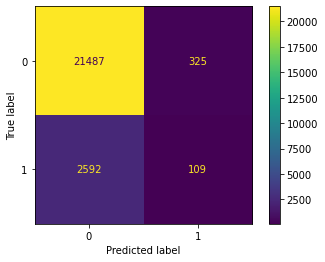

In [91]:
plot_confusion_matrix(knn_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Обучим несколько _kNN_-классификаторов для разных значений _k_ от 5 до 50 с шагом 5, при этом будем собирать значения полученных ошибок, чтобы потом проанализировать результаты.

In [83]:
%%time

acc_train = []
err_train = []
acc_test = []
err_test = []

k_values = range(5, 51, 5)

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    print('k = {}:'.format(k))
    
    y_train_pred = knn_model.predict(X_train)
    print('    Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
    print('             Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))
    acc_train.append(accuracy_score(y_train, y_train_pred))
    err_train.append(np.mean(y_train != y_train_pred))
    
    y_test_pred = knn_model.predict(X_test)
    print('    Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
    print('             Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))
    acc_test.append(accuracy_score(y_test, y_test_pred))
    err_test.append(np.mean(y_test != y_test_pred))

k = 5:
    Accuracy score on train data: 89.36%
             Error on train data: 10.64%
    Accuracy score on test  data: 88.10%
             Error on test  data: 11.90%
k = 10:
    Accuracy score on train data: 88.82%
             Error on train data: 11.18%
    Accuracy score on test  data: 88.89%
             Error on test  data: 11.11%
k = 15:
    Accuracy score on train data: 88.77%
             Error on train data: 11.23%
    Accuracy score on test  data: 88.90%
             Error on test  data: 11.10%
k = 20:
    Accuracy score on train data: 88.69%
             Error on train data: 11.31%
    Accuracy score on test  data: 89.00%
             Error on test  data: 11.00%
k = 25:
    Accuracy score on train data: 88.69%
             Error on train data: 11.31%
    Accuracy score on test  data: 88.97%
             Error on test  data: 11.03%
k = 30:
    Accuracy score on train data: 88.68%
             Error on train data: 11.32%
    Accuracy score on test  data: 88.97%
          

Посмотрим на графики за значениями точности и ошибки на тренировочном и тестовом наборах при различных значениях k

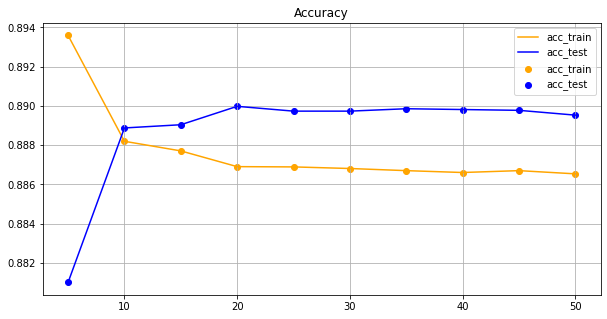

In [84]:
fig = plt.figure(figsize=(10, 5))

plt.title('Accuracy')
plt.scatter(list(k_values)[::-1], acc_train[::-1], color='orange', label='acc_train')
plt.plot(list(k_values)[::-1], acc_train[::-1], color='orange', label='acc_train')

plt.scatter(list(k_values)[::-1], acc_test[::-1], color='blue', label='acc_test')
plt.plot(list(k_values)[::-1], acc_test[::-1], color='blue', label='acc_test')

plt.grid()
plt.legend()

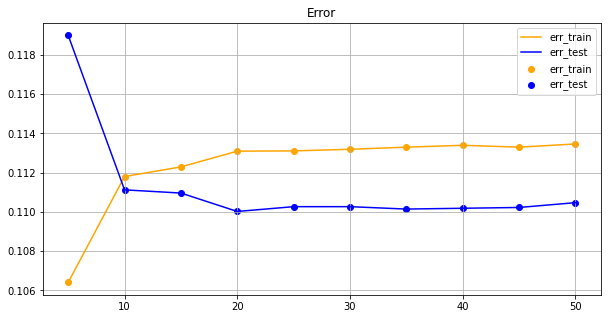

In [85]:
fig = plt.figure(figsize=(10, 5))

plt.title('Error')
plt.scatter(list(k_values)[::-1], err_train[::-1], color='orange', label='err_train')
plt.plot(list(k_values)[::-1], err_train[::-1], color='orange', label='err_train')

plt.scatter(list(k_values)[::-1], err_test[::-1], color='blue', label='err_test')
plt.plot(list(k_values)[::-1], err_test[::-1], color='blue', label='err_test')

plt.grid()
plt.legend()

Наилучшая точность получена при ___k = 20___, однако разница не столь велика. Точность держится на уровне 88-89%. Имеет смысл сравнить с другими типами классификаторов.

### Алгоритм Random Forest

Обучим классификатор на основе алгоритма _Random Forest_

In [93]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_train, y_train)

CPU times: user 1min 40s, sys: 10.4 s, total: 1min 51s
Wall time: 1min 53s


RandomForestClassifier(n_estimators=500)

Вычисляем ошибку на тренировочной выборке

In [94]:
%%time
y_train_pred = rf_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 100.00%
         Error on train data: 0.00%
CPU times: user 19.1 s, sys: 4.76 s, total: 23.8 s
Wall time: 23.8 s


Вычисляем ошибку на тестовой выборке

In [95]:
%%time
y_test_pred = rf_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.99%
         Error on test  data: 11.01%
CPU times: user 6.47 s, sys: 23.1 ms, total: 6.49 s
Wall time: 7.01 s


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


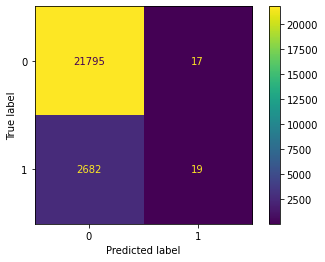

In [96]:
plot_confusion_matrix(rf_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _Random Forest_ не улучшило результаты.

In [106]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

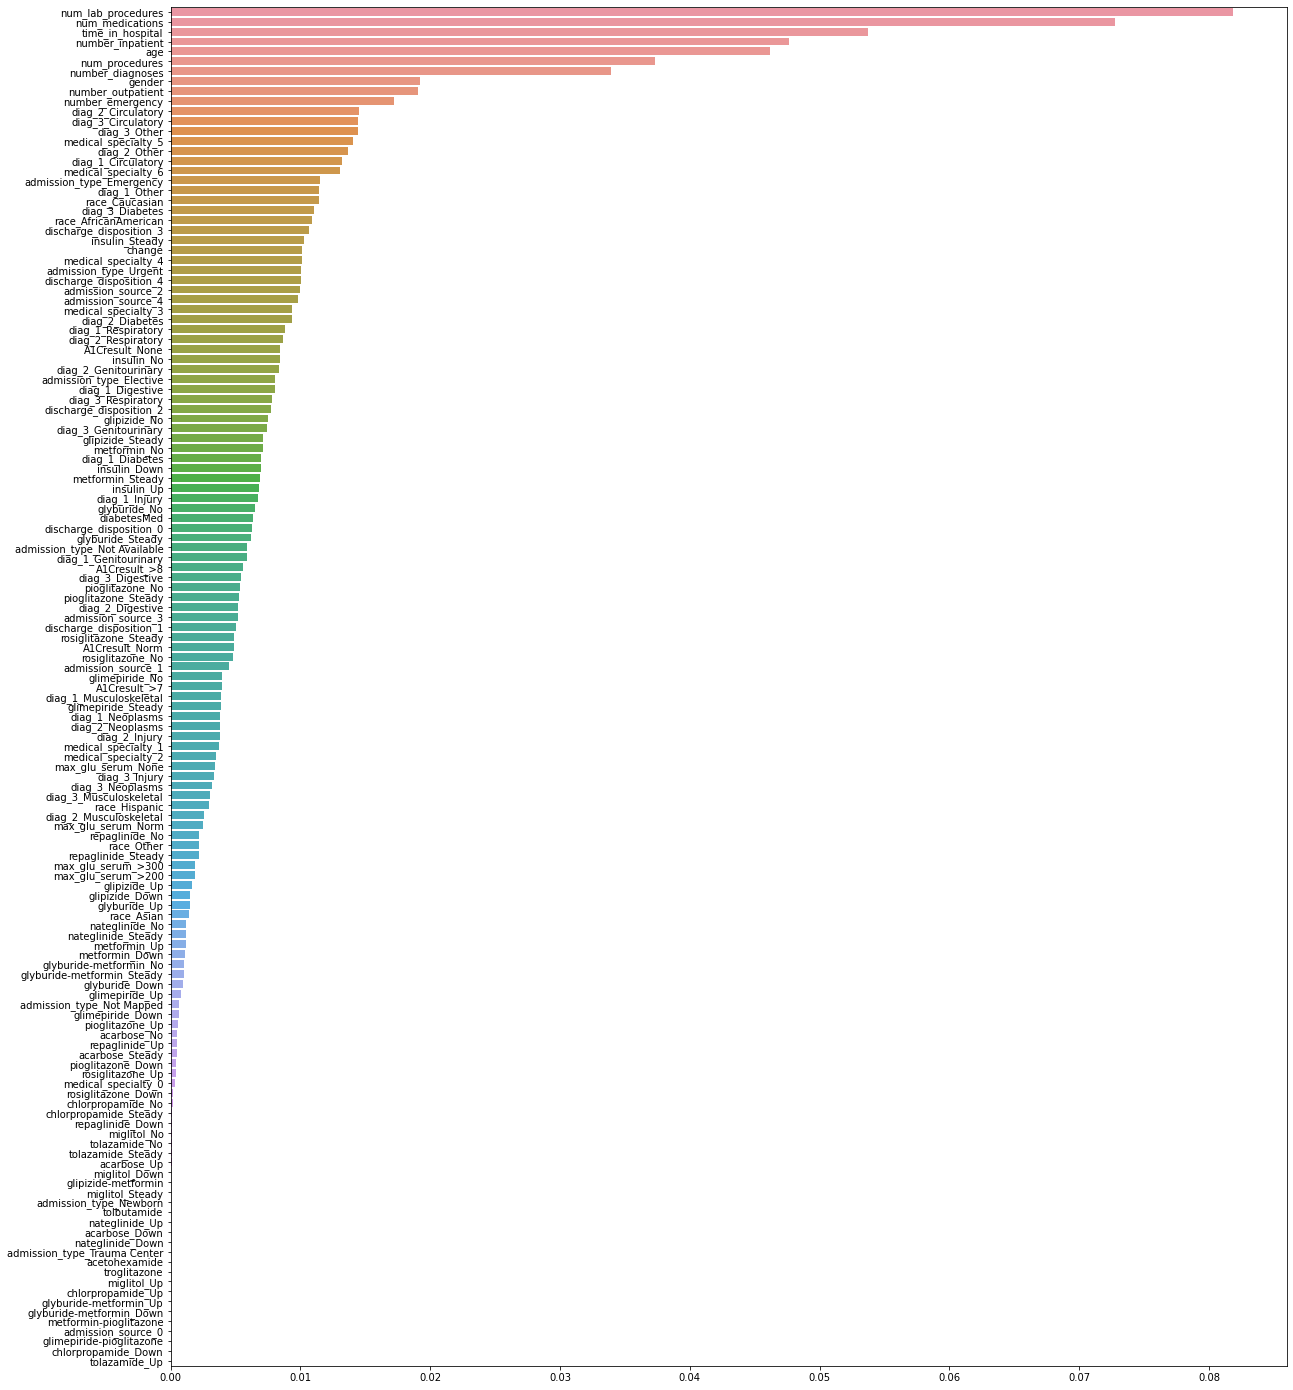

In [107]:
fig = plt.figure(figsize=(20, 25))
sns.barplot(y=importances.index, x=importances, orient='h')
pass

### Алгоритм Logistic Regression

Обучим классификатор на основе алгоритма _Logistic Regression_

In [98]:
%%time

from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(solver='newton-cg')
lr_model.fit(X_train, y_train)

CPU times: user 48.4 s, sys: 4.95 s, total: 53.4 s
Wall time: 27.6 s


LogisticRegression(solver='newton-cg')

Вычисляем ошибку на тренировочной выборке

In [99]:
y_train_pred = lr_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.62%
         Error on train data: 11.38%


Вычисляем ошибку на тестовой выборке

In [100]:
y_test_pred = lr_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.90%
         Error on test  data: 11.10%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


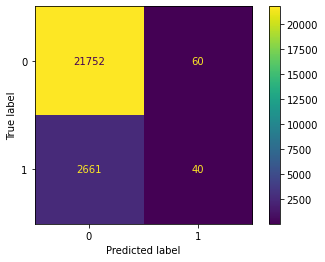

In [101]:
plot_confusion_matrix(lr_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _Logistic Regression_ также не улучшило результаты.

### Алгоритм SGDClassifier

Обучим классификатор на основе алгоритма _SGD_

In [102]:
%%time

from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss='log', random_state=58)
sgd_model.fit(X_train, y_train)

CPU times: user 2.05 s, sys: 22.5 ms, total: 2.07 s
Wall time: 2.09 s


SGDClassifier(loss='log', random_state=58)

Вычисляем ошибку на тренировочной выборке

In [103]:
y_train_pred = sgd_model.predict(X_train)
print('Accuracy score on train data: {:.2f}%'.format(100 * accuracy_score(y_train, y_train_pred)))
print('         Error on train data: {:.2f}%'.format(100 * np.mean(y_train != y_train_pred)))

Accuracy score on train data: 88.43%
         Error on train data: 11.57%


Вычисляем ошибку на тестовой выборке

In [104]:
y_test_pred = sgd_model.predict(X_test)
print('Accuracy score on test  data: {:.2f}%'.format(100 * accuracy_score(y_test,  y_test_pred)))
print('         Error on test  data: {:.2f}%'.format(100 * np.mean(y_test != y_test_pred)))

Accuracy score on test  data: 88.49%
         Error on test  data: 11.51%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


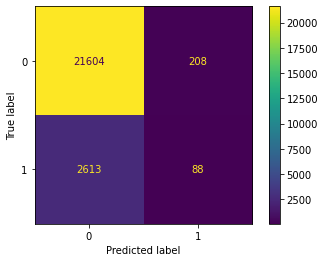

In [105]:
plot_confusion_matrix(sgd_model, X_test, y_test)

Глядя на матрицу рассогласования, видно, что из-за несбалансированности классов, качество работы нашей обученной модели оставляет желать лучшего.

Использование алгоритма _SGD_ также не улучшило результаты.

## Выводы

* Лучшая точность, которой удалось добиться на тестовой выборке - 89% достигнута методом _kNN_ при _k = 20_.
* Ни один из других предложенных алгоритмов не смог добиться лучшей точности. Но при этом все алгоритмы показывают приблизительно похожую точность предсказывания на тестовой выборке.
* По матрицам рассогласования для обученных моделей можно сказать, что у всех из них довольно велико значение ошибки второго рода, что опасно. Возможно, получится улучшить результаты после борьбы с несбалансированностью классов.
* Метод _kNN_ по времени работает сильно дольше остальных методов.